In [27]:
import matplotlib
font = {'size'   :14}

matplotlib.rc('font', **font)

The website [goodreads.com](https://www.goodreads.com) lets readers rate books on a scale of 1 – 5 and also reports a "scale" for lists of related books, according to some undisclosed algorithm. For the novels of Agatha Christie, [a list can be seen here](https://www.goodreads.com/list/show/2126.Best_Agatha_Christie_Book). Goodreads has come in for [some criticism](https://www.newstatesman.com/science-tech/social-media/2020/08/better-goodreads-possible-bad-for-books-storygraph-amazon) for its poor user experience, and certainly it isn't always clear what to make of its ratings.

This article will use [pandas](https://pandas.pydata.org/) to anaylse and compare the ratings and scores given to Agatha Christie's novels on Goodreads with the reviews on the excellent podcast, [_All About Agatha_](https://www.facebook.com/allaboutagatha/). These reviews result in ratings for plot mechanics, credibility, setting, etc., along with deductions for the any of the more egregious racism, anti-semitism, and all-round crassness that her novels occasionally display.

The file `ac-ratings.csv` lists the Goodreads ratings and scores along with the _All About Agatha_ ratings in comma-separated format. Every Agatha Christie novel (apart from the execrable *Passenger to Frankfurt*) is listed from Goodreads. At the time of writing, the podcast (which reviews the books in chronological order) has reached _Cat Among the Pigeons_ (1959) with 15 novels to go.

First take a quick look at the CSV file:

In [28]:
!head ac-ratings.csv

The first two lines are the header: the first three columns are the book title, year of publication and novel series (Miss Parple, Poirot, etc.); the next eight columns relate to the rankings given by *All About Agatha*, with the total rating in the last of these columns; the next four columns are the score and rating statistics from Goodreads.

Reading in this file is straightfoward with pandas' `read_csv` routine. We will set the index to be the book title and take column names from the header from the second line.

In [29]:
import pandas as pd
df = pd.read_csv('ac-ratings.csv', header=1, index_col=0)

With the DataFrame in this form it is easy to obtain some simple metrics. First, the top-rated novel:

In [30]:
print('Best novel, rated by Goodreads: "{}"'.format(df['Average Rating'].idxmax()))

Best novel, rated by Goodreads: "And Then There Were None"


The 10 books with the most credible plots (according to *All About Agatha*):

In [31]:
print('Top 10 books, ranked by credibility (according to AAA):')
print(df['Credibility'].sort_values(ascending=False)[:10])

Top 10 books, ranked by credibility (according to AAA):
Title
The Hollow                      9.0
And Then There Were None        8.0
The Murder of Roger Ackroyd     8.0
Peril at End House              8.0
Murder at the Vicarage          8.0
Five Little Pigs                8.0
Cards on the Table              8.0
Murder on the Orient Express    8.0
The Man in the Brown Suit       7.0
Crooked House                   7.0
Name: Credibility, dtype: float64


The 10 books with the most ratings on Goodreads:

In [32]:
print('Top 10 most rated books on Goodreads:')
print(df['Number of Ratings'].sort_values(ascending=False)[:10])

Top 10 most rated books on Goodreads:
Title
And Then There Were None           848665
Murder on the Orient Express       392309
The Mysterious Affair at Styles    264089
The Murder of Roger Ackroyd        159882
Murder at the Vicarage             147651
Death on the Nile                  136127
The A.B.C. Murders                 102429
The Man in the Brown Suit           84843
The Body in the Library             68452
The Murder on the Links             51703
Name: Number of Ratings, dtype: int64


It is often claimed that Agatha Christie's novels get worse over time. We can plot the rating against publication year, but perhaps should exclude *Curtain* and *Sleeping Murder*, which were published long after they were written.

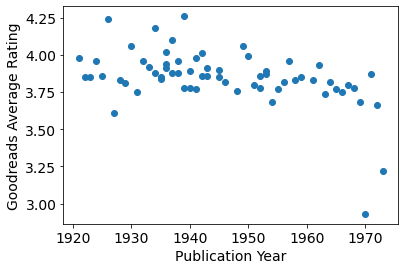

In [33]:
import matplotlib.pyplot as plt
df2 = df.drop(['Curtain', 'Sleeping Murder'])
plt.scatter(df2['Publication Year'], df2['Average Rating'])
plt.xlabel('Publication Year')
plt.ylabel('Goodreads Average Rating');

Two things are interesting: there appears to be much more variation in rating for Christie's novels of the 1920s and 30s, and there does seem to be a decline over time (even discounting the two outliers towards the end of her career (*Passenger to Frankfurt* and *Postern of Fate*). Charitably excluding these outliers, we can perform a linear regression:

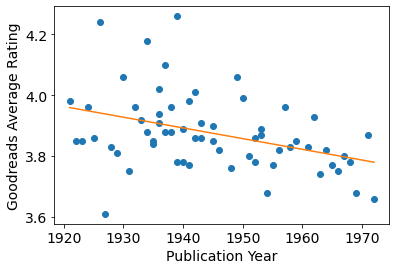

In [34]:
from sklearn.linear_model import LinearRegression

# Drop the outliers.
df3 = df2.drop(['Passenger to Frankfurt', 'Postern of Fate'])
# We require column vectors (n, 1) for the data, so add an axis.
X = df3.loc[:, "Publication Year"].values[:, None]
Y = df3.loc[:, "Average Rating"].values[:, None]

linear_regressor = LinearRegression()
reg = linear_regressor.fit(X, Y)
Ypred = linear_regressor.predict(X)

plt.scatter(X, Y)
plt.plot(X, Ypred, c='tab:orange')
plt.xlabel('Publication Year')
plt.ylabel('Goodreads Average Rating');

As can be seen from the above plot, the regression coefficient is negative:

In [35]:
reg.coef_

array([[-0.00352198]])

If Agatha Christie were writing books today, her average Goodreads rating could be expected to be:

In [36]:
reg.predict([[2021]])

array([[3.60753163]])

(about the same as *Fifty Shades of Grey*, as it turns out).

Does the number of ratings on Goodreads correlate with the ratings themselves?

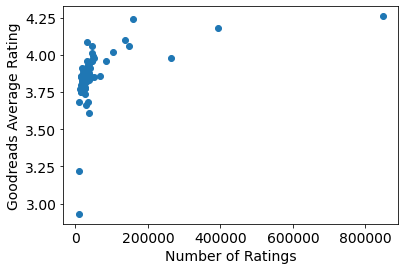

In [37]:
plt.scatter(df['Number of Ratings'], df['Average Rating'])
plt.xlabel('Number of Ratings')
plt.ylabel('Goodreads Average Rating');

Yes, but in a rather non-linear way: the best novels get orders of magnitude more ratings than the others. The cleanest way to visualize these data is to take the logarithm of the number of ratings, therefore:

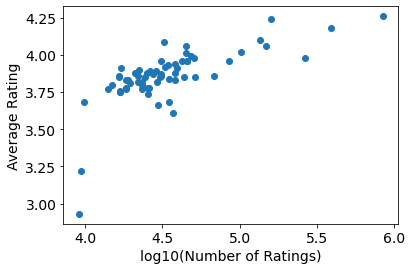

In [38]:
import numpy as np
plt.scatter(np.log10(df['Number of Ratings']), df['Average Rating'])
plt.xlabel('log10(Number of Ratings)')
plt.ylabel('Average Rating');

pandas' powerful `groupby` function can analyse the novels by grouping them in different ways.

For example, the number of novels published each year:

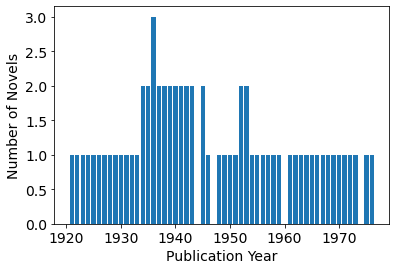

In [39]:
g_year = df.groupby('Publication Year')
novels_per_year = g_year.size()
plt.bar(novels_per_year.index, novels_per_year)
plt.xlabel('Publication Year')
plt.ylabel('Number of Novels');

The DataFrame can be grouped on the "Series" column to count the number of novels featuring each detective:

In [40]:
g_series = df.groupby('Series')
print('Number of novels by series')
print(g_series.size())

Number of novels by series
Series
Colonel Race              2
Miss Marple              12
Poirot                   33
Superintendent Battle     4
Tommy and Tuppence        4
dtype: int64


The same `GroupBy` object can by used to find the average rating within each novel series:

In [41]:
print('Mean rating for each series')
with pd.option_context('display.float_format', '{:,.2f}'.format):
    # Inside this context, floating point numbers are printed with 2 d.p.
    print(g_series['Average Rating'].mean())

Mean rating for each series
Series
Colonel Race            3.93
Miss Marple             3.89
Poirot                  3.89
Superintendent Battle   3.84
Tommy and Tuppence      3.66
Name: Average Rating, dtype: float64


Which is the better Goodreads metric of quality, the Average Rating or the "Score"? One way to answer this is to compare with the rating given by the *All About Agatha* podcast (assuming this agrees with either of them). To compare ratings, we can rescale the AAA Total by a factor of 1/10, since the maximum rating they give is 50.

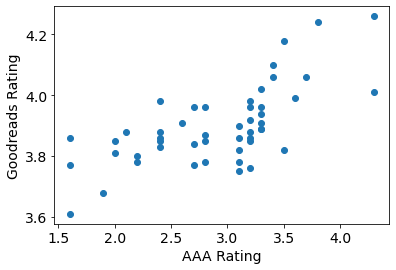

In [42]:
plt.scatter(df['Total']/10, df['Average Rating'])
plt.xlabel('AAA Rating')
plt.ylabel('Goodreads Rating');

The _All About Agatha_ podcast is clearly harsher, on average, than the Goodreads rankers: this is to be expected: they are reviewing the novels systematically whereas the drive-by punters of Goodreads are more likely to provide a rating when they enjoyed a book (and may not even finish a book they don't enjoy). However, there is a pleasing trend with the following correlation coefficient:

In [43]:
df['Total'].corr(df['Average Rating'])

0.6690381152943653

To compare the AAA ratings with the Goodread scores, it makes sense to take the logarithm of the latter:

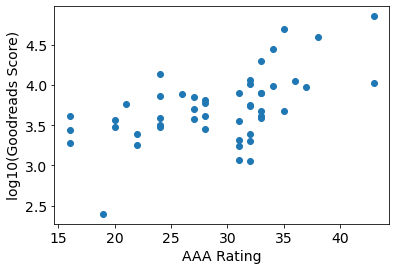

In [44]:
# Because of the missing score for "Passenger to Frankfurt", we must convert
# the Score column to a numeric form, with NaN for this invalid value.
scores = pd.to_numeric(df['Score'], errors='coerce')
plt.scatter(df['Total'], np.log10(scores))
plt.xlabel('AAA Rating')
plt.ylabel('log10(Goodreads Score)');

In [45]:
df['Total'].corr(np.log10(scores))

0.5469768471725293

The correlation seems less strong: apparently the wisdom of the crowds is not improved by whatever algorithm Goodreads uses to generate its Score metric.